In [1]:
from pathlib import Path
import logging
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator
from sklearn.model_selection import train_test_split, GridSearchCV

from MatrixFactorization.PMF import PMF

root_dir = Path.cwd() / Path('../data/ml-latest-small')
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger('my_logger')

In [2]:
movies = pd.read_csv(root_dir / 'movies.csv')
ratings = pd.read_csv(root_dir / 'ratings.csv')
movies.movieId = movies.movieId - 1
ratings.userId = ratings.userId - 1
ratings.movieId = ratings.movieId - 1

In [3]:
display(movies.head(2))
display(ratings.head(2))

,movieId,title,genres
0,0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,1,Jumanji (1995),Adventure|Children|Fantasy


,userId,movieId,rating,timestamp
0,0,0,4.0,964982703
1,0,2,4.0,964981247


# Maximum a posteriori

\begin{align}
u_i &= \left(\lambda \sigma^2 I + \sum_{j \in \Omega_{u_i}} v_j v_j^T \right)^{-1} \left( \sum_{j \in \Omega_{u_i}} M_{ij} v_j\right) \\
v_i &= \left(\lambda \sigma^2 I + \sum_{i \in \Omega_{v_j}} u_j u_j^T \right)^{-1} \left(\sum_{i \in \Omega_{v_j}} M_{ij} u_j \right) \\
\end{align}




In [4]:
ratings2 = ratings.query('movieId < 300').iloc[:,:3].values.astype(np.int)
print(ratings2.shape)
dims = {}
dims['N'] = ratings2[:,0].max() + 1
dims['M'] = ratings2[:,1].max() + 1

(8253, 3)


CPU times: user 1min 20s, sys: 9.57 s, total: 1min 30s
Wall time: 27.6 s


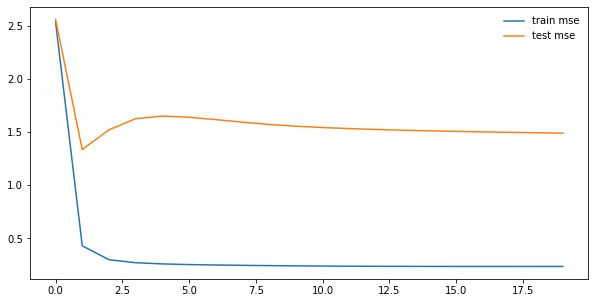

In [5]:
%%time
params = {'dims': dims, 'dim_D': 10, 'lambda_': 1, 'sigma2': 2, 'epoch_num': 20, 'logger': None}
train_r, test_r = train_test_split(ratings2, test_size=0.2)

pmf = PMF(**params).fit(train_r)
train_mse = pmf.compute_hitstorical_errors(train_r)
test_mse = pmf.compute_hitstorical_errors(test_r)
result = pd.concat([train_mse.to_frame('train mse'),
                    test_mse.to_frame('test mse')], axis=1)

fig, ax = plt.subplots(figsize=(10,5), facecolor='white')
result.plot(ax=ax)
plt.legend(frameon=False)

In [15]:
%%time
pmf = PMF(**params)
tuned_parameters = {'dim_D': [2, 5, 10, 15], 'lambda_': [0.1, 0.5, 1, 2, 5], 'sigma2': [0.1, 0.5, 1, 2, 5]}
gs = GridSearchCV(pmf, tuned_parameters, cv=5)
gs.fit(ratings2)

KeyError: 'D'

In [13]:
gs.cv_results_

{'mean_fit_time': array([17.97094536, 17.38704376]),
 'std_fit_time': array([8.8921921 , 8.59598994]),
 'mean_score_time': array([0.05691481, 0.05534759]),
 'std_score_time': array([0.03495034, 0.03286832]),
 'param_lambda_': masked_array(data=[0.1, 0.5],
              mask=[False, False],
        fill_value='?',
             dtype=object),
 'param_sigma2': masked_array(data=[0.1, 0.1],
              mask=[False, False],
        fill_value='?',
             dtype=object),
 'params': [{'lambda_': 0.1, 'sigma2': 0.1}, {'lambda_': 0.5, 'sigma2': 0.1}],
 'split0_test_score': array([13.2870294 , 13.28511189]),
 'split1_test_score': array([13.07496889, 13.07212245]),
 'split2_test_score': array([12.90603569, 12.89092573]),
 'split3_test_score': array([12.78470249, 12.78306222]),
 'split4_test_score': array([nan, nan]),
 'mean_test_score': array([nan, nan]),
 'std_test_score': array([nan, nan]),
 'rank_test_score': array([1, 2], dtype=int32)}